# Parameter estimation - Eddington experiment
- [Problem sheet](https://github.com/nyctophile-aayu/Astronomical-Data-Analysis/blob/main/Problem_Eddington.pdf)
- [Dyson, Eddington and Davidson 1920 paper (Phil. Trans. R. Society, 220, 571)](http://rsta.royalsocietypublishing.org/content/roypta/220/571-581/291.full.pdf)

The aim of this exercise is to analyse photographic plates from Eddington’s 1919 eclipse expedition, to determine whether the data favour Newtonian gravity or Einstein’s General Theory of Relativity. Light from stars that passes close to the Sun is deflected, and during an eclipse, these stars can be detected and their displacements measured, when compared with photographs taken when the Sun is far away.

General Relativity predicts that light passing a mass M at distance r will be bent through an angle

\begin{equation}
    \theta_{\text{GR}}(r)
    =
    \frac{4 G M}{r c^{2}}
\end{equation}

whereas an argument based on Newtonian gravity gives half this:

\begin{equation}
    \theta_{\text{N}}(r)
    =
    \frac{2 G M}{r c^{2}}
\end{equation}

We can either treat this as a parameter inference problem, modelling the bending as

\begin{equation}
    \theta(r)
    =
    \frac{\alpha G M}{r c^{2}}
\end{equation}

and inferring $\alpha$, or as a model comparison problem. For this exercise we will
do the former.
### Data model

\begin{equation}
\begin{aligned}
    Dx^{\text{model exp.}}(\theta, x, y, E_{x}) &= a x + b y + c + \alpha E_{x} \\
    Dy^{\text{model exp.}}(\theta, x, y, E_{y}) &= d x + e y + f + \alpha E_{y}
\end{aligned}
\end{equation}

where:
- $x$, $y$: coordinates of the stars
- $E_{x}$, $E_{y}$: coefficients of the gravitational displacement
- $c$, $f$: corrections to zero
- $a$, $e$: differences of scale value (caused e.g. by changes in temperature)
- $b$, $d$: depend on the orientiation of the two plates
- $\alpha$: deflection at unit distance, i.e (50' from the Sun's centre)


**Parameter of Interest (POI):**
- $\alpha$

**Nuisance parameters (NP):**
- $a$, $b$, $c$, $d$, $e$, $f$
**Parameter vector:**

\begin{equation}
    \mathbf{\theta} = (\alpha, a,b,c,d,e,f)
\end{equation}
**Combined likelihood:**

\begin{equation}
    \mathcal{L} (\theta, \text{all data})
    =
    \prod_{i=star} \mathcal{L}_{i} (\theta, Dx^{\text{obs}}, Dy^{\text{obs}})
\end{equation}

where $\mathcal{L}_{i}$ is:

\begin{equation}
\begin{aligned}
    \mathcal{L}_{i}
    =
    &\frac{1}{\sqrt{2 \pi} \sigma_{Dx}}
    \exp{ \left\{  - \frac{1}{2} \frac{(Dx^{\text{obs}}_{i} - Dx^{\text{model exp.}} (\theta,x_{i},y_{i},E_{x,i}) )^{2}}{\sigma^{2}_{Dx}} \right\} }
    \cdot \\
    &\frac{1}{\sqrt{2 \pi} \sigma_{Dy}}
    \exp{  \left\{ -  \frac{1}{2} \frac{(Dy^{\text{obs}}_{i} - Dy^{\text{model exp.}} (\theta,x_{i},y_{i},E_{y,i}))^{2}}{\sigma^{2}_{Dy}} \right\} }
\end{aligned}
\end{equation}
where:
- $\sigma_{Dx} = 0.05$
- $\sigma_{Dy} = 0.05$

###Required Libraries###

In [2]:
import numpy as np
import scipy.stats
import scipy.constants
import matplotlib.pyplot as plt
import math
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

### Loading in data###

In [11]:
#Data is imported and stored here
stars = pd.read_table('https://raw.githubusercontent.com/nyctophile-aayu/Astronomical-Data-Analysis/main/eddington.dat', skiprows=[0], delim_whitespace=True)

#Correcting value of Dx and Dy by subtracting -1.500 in Dx and -1.324 in Dy
stars['Dx_obs_corrected'], stars['Dy_obs_corrected'] = (stars.Dx_obs_uncorrected + 1.500), (stars.Dy_obs_uncorrected + 1.324)

# Extracting data from pandas DataFrame
x,y,Ex,Ey,Dx,Dy = stars.x, stars.y, stars.Ex, stars.Ey, stars.Dx_obs_corrected, stars.Dy_obs_corrected

# Storing all the values in single array 
data = np.array([x,y,Ex,Ey,Dx,Dy])

###Likelihood Function###


In [15]:
# Log of likelihood is defined here
def log_Likelihood(theta, data=data, sigmad = [0.05,0.05]):
  Dx_model = theta[1]*data[0] + theta[2]*data[1] + theta[3] + theta[0]*data[2]
  Dy_model = theta[4]*data[0] + theta[5]*data[1] + theta[6] + theta[0]*data[3]
 
  Diff_x= data[4] - Dx_model
  Diff_y= data[5] - Dy_model

  lnL = (-1/(2*sigmad[0]**2) * np.dot(Diff_x , Diff_x))+(-1/(2*sigmad[1]**2) * np.dot(Diff_y , Diff_y))
  return lnL

###Metropolis-Hastings sampler###

In [17]:
def MH_sampler(M,N,theta_in,sigma):
    alpha_accepted = []
    a_accepted     = []
    b_accepted     = []
    c_accepted     = []
    d_accepted     = []
    e_accepted     = []
    f_accepted     = []
    acceptance_likelihood = []
    Naccepted = []

    for i in range(M):
        Naccept = 0
        alpha_accept = [theta_in[0][i]]
        a_accept     = [theta_in[1][i]]
        b_accept     = [theta_in[2][i]]
        c_accept     = [theta_in[3][i]]
        d_accept     = [theta_in[4][i]]
        e_accept     = [theta_in[5][i]]
        f_accept     = [theta_in[6][i]]
        acpt_L       = []
        # theta_accept = np.array([alpha_accept, a_accept, b_accept, c_accept, d_accept, e_accept, f_accept])
        for j in range(N):  
            theta_accept = np.array([alpha_accept[-1], a_accept[-1], b_accept[-1], c_accept[-1], d_accept[-1], e_accept[-1], f_accept[-1]])
            #Generating random values of h and Omega_m in range (0,1) with Gaussian proposal distribution
            alpha_random = np.random.normal(alpha_accept[-1], sigma[0]) 
            a_random     = np.random.normal(a_accept[-1], sigma[1])     
            b_random     = np.random.normal(b_accept[-1], sigma[2])     
            c_random     = np.random.normal(c_accept[-1], sigma[3])     
            d_random     = np.random.normal(d_accept[-1], sigma[4])     
            e_random     = np.random.normal(e_accept[-1], sigma[5])     
            f_random     = np.random.normal(f_accept[-1], sigma[6])  
            theta_random = [alpha_random, a_random, b_random, c_random, d_random, e_random, f_random]   

            #Calulating log of likelihood of these randomly generated 
            new_log_L = log_Likelihood(theta_random, data)

            '''
            Now, calulating acceptance probability and taking minimum 1 and ratio of likelihood of new value of parameters to previous accepted values.
            If the ratio of likelihood is increased then it is accepted without condition.
            But if the likelihood goes down in next step then it would be accepted with uniform probability.
            '''

            acc_L = min(np.exp(new_log_L - log_Likelihood(theta_accept, data)), 1)

            if np.random.uniform(0, 1) < acc_L:
                alpha_accept   = np.append(alpha_accept, alpha_random)
                a_accept       = np.append(a_accept, a_random)
                b_accept       = np.append(b_accept, b_random)
                c_accept       = np.append(c_accept, c_random)
                d_accept       = np.append(d_accept, d_random)
                e_accept       = np.append(e_accept, e_random)
                f_accept       = np.append(f_accept, f_random)
                acpt_L         = np.append(acpt_L, new_log_L)
                Naccept += 1

        alpha_accepted.append(alpha_accept)
        a_accepted.append(a_accept)
        b_accepted.append(b_accept)
        c_accepted.append(c_accept)
        d_accepted.append(d_accept)
        e_accepted.append(e_accept)
        f_accepted.append(f_accept)
        acceptance_likelihood.append(acpt_L)
        Naccepted.append(Naccept)
        theta_accepted = np.array([alpha_accepted, a_accepted, b_accepted, c_accepted, d_accepted, e_accepted, f_accepted])
    return theta_accepted, acceptance_likelihood, Naccepted

In [18]:
# Simulating M chains for N samples each
M = 5
N = 10000
Nburn = 250
sigma = [0.015, 0.015, 0.015, 0.015,0.015, 0.015, 0.015]
theta_in = np.array([[0.0, 0.35, 0.60, 0.75, 0.99],
                    [0.0, 0.35, 0.60, 0.75, 0.99],
                    [0.0, 0.35, 0.60, 0.75, 0.99],
                    [0.0, 0.35, 0.60, 0.75, 0.99],
                    [0.0, 0.35, 0.60, 0.75, 0.99],
                    [0.0, 0.35, 0.60, 0.75, 0.99],
                    [0.0, 0.35, 0.60, 0.75, 0.99]])
theta_accepted, acceptance_likelihood, Naccepted = MH_sampler(M,N,theta_in, sigma)

###Plots and Observations###

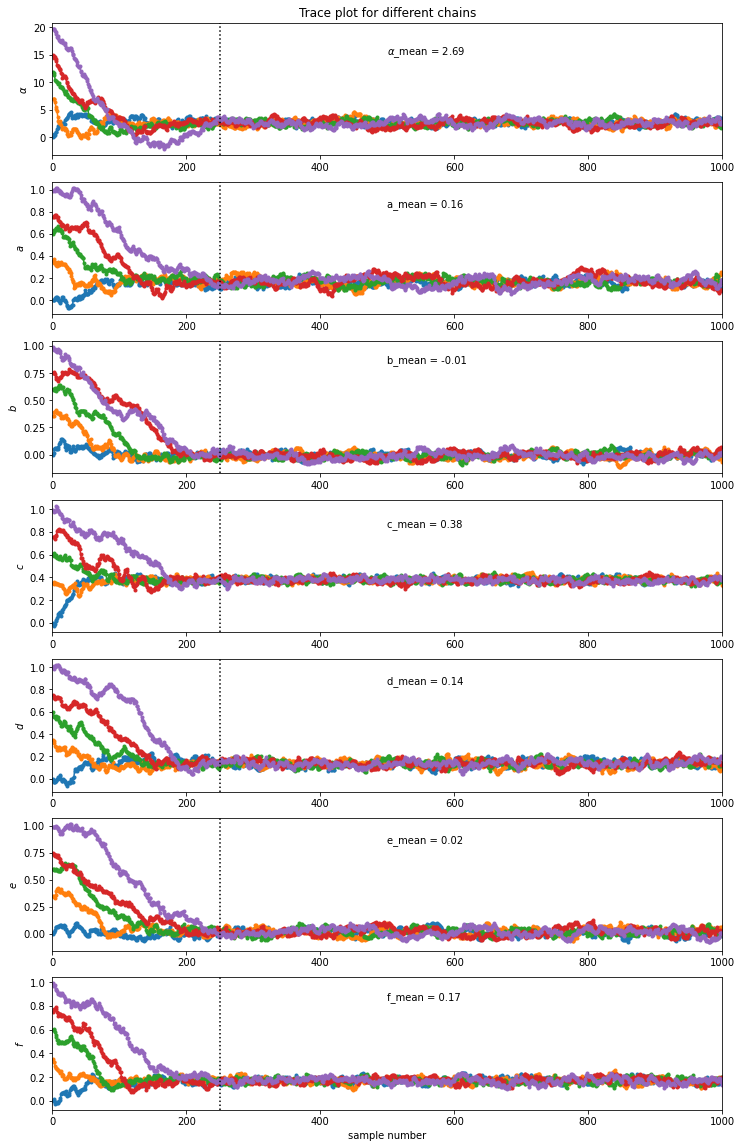

In [19]:
# Combining all the chains to create larger sample
alpha_all = []
a_all     = []
b_all     = []
c_all     = []
d_all     = []
e_all     = []
f_all     = []
acc_all   = []
for i in range(M):
    alpha_all = np.append(theta_accepted[0][i][Nburn+1:], alpha_all)
    a_all = np.append(theta_accepted[1][i][Nburn+1:], a_all)
    b_all = np.append(theta_accepted[2][i][Nburn+1:], b_all)
    c_all = np.append(theta_accepted[3][i][Nburn+1:], c_all)
    d_all = np.append(theta_accepted[4][i][Nburn+1:], d_all)
    e_all = np.append(theta_accepted[5][i][Nburn+1:], e_all)
    f_all = np.append(theta_accepted[6][i][Nburn+1:], f_all)
    acc_all = np.append(acceptance_likelihood[i][Nburn:], acc_all)


# Plotting Trace plot for Omega_m and h for all the cains
fig, (ax0, ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(7,1,figsize=(12,20))
ax0.set_xlim(0,1000)
ax0.set_ylabel(r"$\alpha$")
for i in range(M):
    ax0.plot(np.arange(1, Naccepted[i]+2, 1), theta_accepted[0][i]*19.8, marker='.')
ax0.axvline(Nburn, color='black', linestyle=':')
ax0.text(500, 15, r'$\alpha$_mean = {}'.format(np.round(np.mean(alpha_all)*19.8,2)))
ax0.set_title("Trace plot for different chains")

ax1.set_ylabel("$a$")
for i in range(M):
    ax1.plot(np.arange(1, Naccepted[i]+2, 1), theta_accepted[1][i], marker='.')
ax1.axvline(Nburn, color='black', linestyle=':')
ax1.text(500, 0.85, r'a_mean = {}'.format(np.round(np.mean(a_all),2)))
ax1.set_xlim(0,1000)

ax2.set_ylabel("$b$")
for i in range(M):
    ax2.plot(np.arange(1, Naccepted[i]+2, 1), theta_accepted[2][i], marker='.')
ax2.axvline(Nburn, color='black', linestyle=':')
ax2.text(500, 0.85, r'b_mean = {}'.format(np.round(np.mean(b_all),2)))
ax2.set_xlim(0,1000)

ax3.set_ylabel("$c$")
for i in range(M):
    ax3.plot(np.arange(1, Naccepted[i]+2, 1), theta_accepted[3][i], marker='.')
ax3.axvline(Nburn, color='black', linestyle=':')
ax3.text(500, 0.85, r'c_mean = {}'.format(np.round(np.mean(c_all),2)))
ax3.set_xlim(0,1000)

ax4.set_ylabel("$d$")
for i in range(M):
    ax4.plot(np.arange(1, Naccepted[i]+2, 1), theta_accepted[4][i], marker='.')
ax4.axvline(Nburn, color='black', linestyle=':')
ax4.text(500, 0.85, r'd_mean = {}'.format(np.round(np.mean(d_all),2)))
ax4.set_xlim(0,1000)

ax5.set_ylabel("$e$")
for i in range(M):
    ax5.plot(np.arange(1, Naccepted[i]+2, 1), theta_accepted[5][i], marker='.')
ax5.axvline(Nburn, color='black', linestyle=':')
ax5.text(500, 0.85, r'e_mean = {}'.format(np.round(np.mean(e_all),2)))
ax5.set_xlim(0,1000)

ax6.set_ylabel("$f$")
ax6.set_xlabel("sample number")
for i in range(M):
    ax6.plot(np.arange(1, Naccepted[i]+2, 1), theta_accepted[6][i],marker='.')
ax6.axvline(Nburn, color='black', linestyle=':')
ax6.text(500, 0.85, r'f_mean = {}'.format(np.round(np.mean(f_all),2)))
ax6.set_xlim(0,1000)
plt.show()

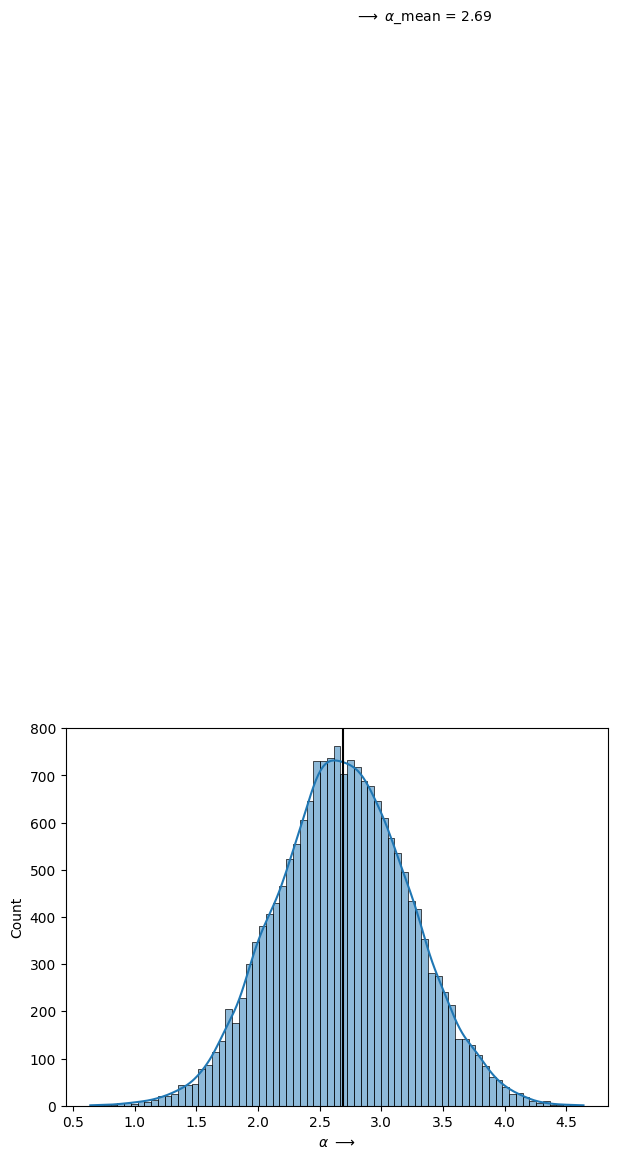

In [20]:
plt.figure(figsize=(7,5), dpi = 100)
sns.histplot(alpha_all*19.8, kde=True, common_norm=True)
plt.xlabel(r'$\alpha$ $\longrightarrow$')
plt.text(np.round(np.mean(alpha_all)*19.8,2)+0.1, 2300, r'$\longrightarrow$ $\alpha$_mean = {}'.format(np.round(np.mean(alpha_all)*19.8,2)))
plt.axvline(np.mean(alpha_all)*19.8, c='black')
plt.show()

Gelman-Rubin test
Parameters:

M: number of chains

N: length of chains

Definitions:

Between-chains variance:
\begin{array}{l}
B \equiv \frac{N}{{M - 1}}\sum\limits_{m = 1}^M {{{\left( {{{\hat \theta }_{\rm{m}}} - \hat \theta } \right)}^2}} \
\end{array} where \begin{array}
\hat \theta  \equiv \frac{1}{M}\sum\limits_{m = 1}^M {{{\hat \theta }_{\rm{m}}}} \\
\end{array}
 
Within-chains variance:
\begin{array}{l}
W \equiv \frac{1}{M}\sum\limits_{m = 1}^M {\sigma _{\rm{m}}^2} \\
\end{array}

Estimators: Estimators of the marginal posterior variance of the estimand:
Underestimates the variance
\begin{array}{l}
{\widehat {{\mathop{\rm var}} }^ - } \equiv W\
\end{array}

Overestimates the variance
\begin{array}{l}
{\widehat {{\mathop{\rm var}} }^ + } \equiv \frac{{N - 1}}{N}W + \frac{{M + 1}}{{MN}}B\
\end{array}

Test:

Potential scale reduction factor: \begin{array}{l}
\hat R \equiv \sqrt {\frac{{{{\widehat {{\mathop{\rm var}} }}^ + }}}{{{{\widehat {{\mathop{\rm var}} }}^ - }}}} \
\end{array}

Test:  \begin{array}{l}
\hat R \to 1\
\end{array} as  \begin{array}{l}
n \to \infty 
\end{array}


In [23]:
# Define Gelman-Rubin Convergence Test
def gelman_rubin_test(M,N,q):
    #Between-Chain Variance
    alpha_mean_each_chain = np.array([np.mean(q[m]) for m in range(M)])
    theta_hat_alpha = np.mean(alpha_mean_each_chain)
    B_alpha = (N/(M-1))*np.sum((alpha_mean_each_chain - theta_hat_alpha)**2)

    #within Chain Variance
    alpha_var_each_chain = np.array([np.var(q[m]) for m in range(M)])
    W_alpha = np.mean(alpha_var_each_chain)

    #Estimators
    var_minus_alpha = W_alpha
    var_plus_alpha = ((N - 1)/N)* W_alpha + ((M+1)/(M*N))*B_alpha

    #Test
    R_hat_alpha = np.sqrt(var_plus_alpha / var_minus_alpha)

    return R_hat_alpha

alpha_all_chains = []
for i in range (M):
    alpha_all_chains.append(theta_accepted[0][i][Nburn:])
R_hat_alpha = gelman_rubin_test(M,N, alpha_all_chains)
print(f'''
R_hat for alpha        = {R_hat_alpha}
''')


R_hat for alpha        = 1.0082638485164255



As \hat{R} is very close to 1 that means chain is converging.

###Solving the same problem using HMC Algorithm
HMC SAMPLER

In [24]:
# All the required functions
def pdf(q, q_mean, q_std):    return (1/(q_std*math.sqrt(2*np.pi)))*math.exp(-math.pow(q - q_mean, 2)/(2*math.pow(q_std, 2)))
def U(q, q_mean, q_std):      return -np.log(pdf(q, q_mean, q_std))
def K(p):      return 0.5*p**2
def H(q, p, q_mean, q_std):   return U(q, q_mean, q_std) + K(p)
def U_grad(q, q_mean, q_std): return (q - q_mean)/np.power(q_std, 2)

# Leapfrog Integrator
def leapfrog(q, p, q_mean, q_std, epsilon, Nsteps):
    for i in range(Nsteps):  
        #Kick
        p = p - 0.5*epsilon*U_grad(q, q_mean, q_std)
        #Drift
        q = q + epsilon*p
        #kick
        p = p - 0.5*epsilon*U_grad(q, q_mean, q_std)
    return q, p

# Array to store accepted value of all parameters
alpha_ac = np.array([])
a_ac     = np.array([])
b_ac     = np.array([])
c_ac     = np.array([])
d_ac     = np.array([])
e_ac     = np.array([])
f_ac     = np.array([])
theta_acc = []

Nac = 0

# Distribution function of all 7 parameters from previous MCMC MH sampling
alpha_mean, alpha_std = np.mean(alpha_all), np.std(alpha_all)
a_mean, a_std = np.mean(a_all), np.std(a_all)
b_mean, b_std = np.mean(b_all), np.std(b_all)
c_mean, c_std = np.mean(c_all), np.std(c_all)
d_mean, d_std = np.mean(d_all), np.std(d_all)
e_mean, e_std = np.mean(e_all), np.std(e_all)
f_mean, f_std = np.mean(f_all), np.std(f_all)

# Initial value to initiate the chain
theta_ac = np.array([0.9,0.9,0.9,0.9,0.9,0.9,0.9])

# Conditions for HMC loop
Nsamps = 50000
epsilon = 0.003
Nsteps = 200

#Loops to propose and accept the parameter points
for i in range(Nsamps):
    
    #Generating random value of momentum with mean 0 and standard deviation 1
    p = np.random.normal(0,1,7)

    alpha_new, p_alpha = leapfrog(theta_ac[0], p[0], alpha_mean, alpha_std, epsilon, Nsteps)
    a_new, p_a         = leapfrog(theta_ac[1], p[1], a_mean, a_std, epsilon, Nsteps)
    b_new, p_b         = leapfrog(theta_ac[2], p[2], b_mean, b_std, epsilon, Nsteps)
    c_new, p_c         = leapfrog(theta_ac[3], p[3], c_mean, c_std, epsilon, Nsteps)
    d_new, p_d         = leapfrog(theta_ac[4], p[4], d_mean, d_std, epsilon, Nsteps)
    e_new, p_e         = leapfrog(theta_ac[5], p[5], e_mean, e_std, epsilon, Nsteps)
    f_new, p_f         = leapfrog(theta_ac[6], p[6], f_mean, f_std, epsilon, Nsteps)
    theta_new = [alpha_new, a_new, b_new, c_new, d_new, e_new, f_new]

    new_lnL = log_Likelihood(theta_new)
    '''
    Again, calulating acceptance probability and taking minimum 1 and ratio of likelihood of values of all parameters to previous accepted value.
    If the ratio of likelihood is increased then it is accepted without condition.
    But if the likelihood goes down in next step then it would be accepted with uniform probability.
    '''
    acc_L = min(np.exp(new_lnL - log_Likelihood(theta_ac)), 1)
    if np.random.uniform(0, 1) < acc_L:
        alpha_ac   = np.append(alpha_ac, alpha_new)
        a_ac       = np.append(a_ac, a_new)
        b_ac       = np.append(b_ac, b_new)
        c_ac       = np.append(c_ac, c_new)
        d_ac       = np.append(d_ac, d_new)
        e_ac       = np.append(e_ac, e_new)
        f_ac       = np.append(f_ac, f_new)
        theta_ac = theta_new
        Nac += 1

In [30]:
print(np.mean(alpha_all)*19.8, np.std(alpha_all)*19.8)

2.692197769569266 0.540137166776673


###Pair Plotting###


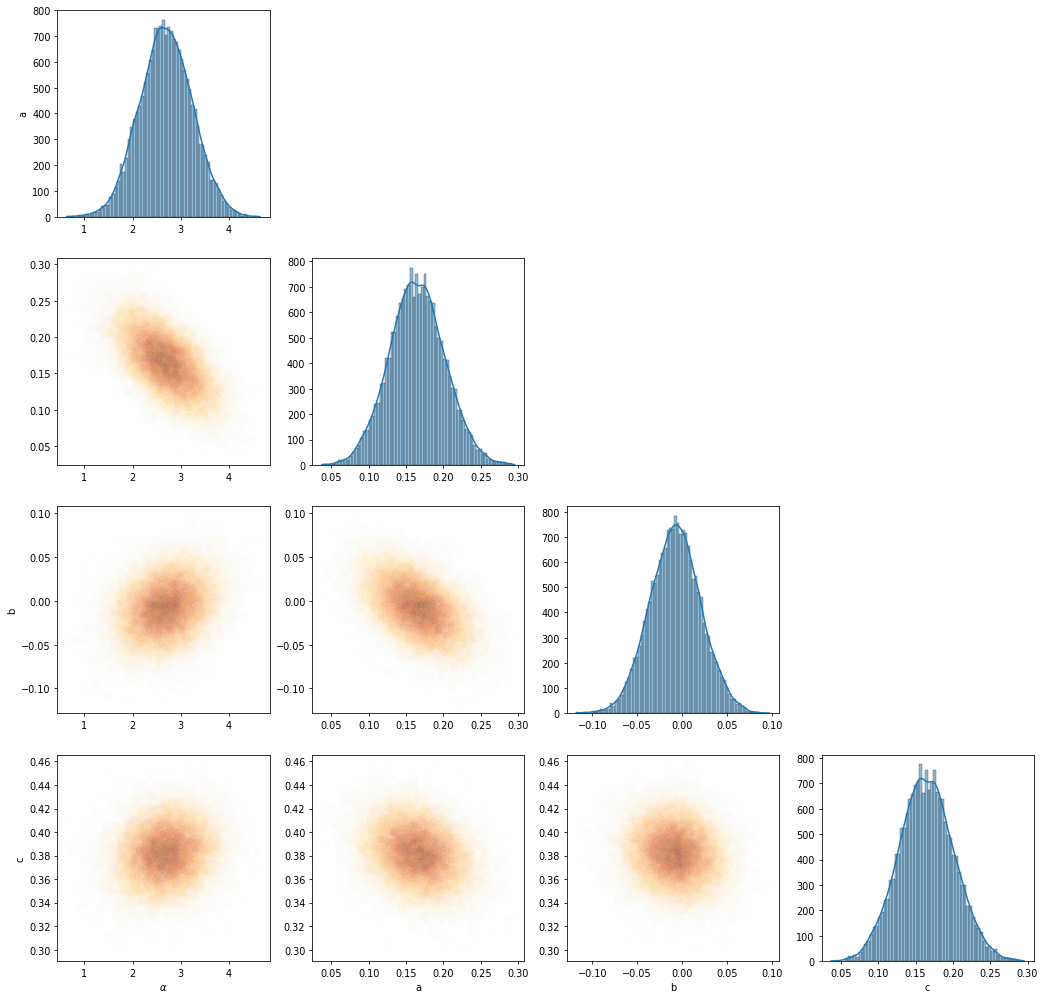

In [28]:
fig, ax = plt.subplots(4, 4, figsize=(18,18), dpi=70)

sns.histplot(alpha_all*19.8, ax=ax[0,0], kde=True)
# ax[0,0].hist(alpha_all*19.8,bins=30)
ax[0,0].set_ylabel(r'$\alpha$')

ax[1,0].scatter(alpha_all*19.8, a_all, c=-np.exp(acc_all), cmap='magma', alpha=0.01)
ax[0,0].set_ylabel('a')

sns.histplot(a_all, ax=ax[1,1], kde=True)
ax[1,1].set_ylabel(None)

ax[2,0].scatter(alpha_all*19.8, b_all, c=-np.exp(acc_all), cmap='magma', alpha=0.01)
ax[2,0].set_ylabel('b')

ax[2,1].scatter(a_all, b_all, c=-np.exp(acc_all), cmap='magma', alpha=0.01)

sns.histplot(b_all, ax=ax[2,2], kde=True)
ax[2,2].set_ylabel(None)

ax[3,0].scatter(alpha_all*19.8, c_all, c=-np.exp(acc_all), cmap='magma', alpha=0.01)
ax[3,0].set_ylabel('c')
ax[3,0].set_xlabel(r'$\alpha$')

ax[3,1].scatter(a_all, c_all, c=-np.exp(acc_all), cmap='magma', alpha=0.01)
ax[3,1].set_xlabel('a')

ax[3,2].scatter(b_all, c_all, c=-np.exp(acc_all), cmap='magma', alpha=0.01)
ax[3,2].set_xlabel('b')

sns.histplot(a_all, ax=ax[3,3], kde=True)
ax[3,3].set_ylabel(None)
ax[3,3].set_xlabel('c')

fig.delaxes(ax[0,1])
fig.delaxes(ax[0,2])
fig.delaxes(ax[0,3])
fig.delaxes(ax[1,2])
fig.delaxes(ax[1,3])
fig.delaxes(ax[2,3])

plt.show()